In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 140)
DATA_PATH = None

In [2]:
if DATA_PATH is not None and Path(DATA_PATH).exists():
    df = pd.read_csv(DATA_PATH) if str(DATA_PATH).lower().endswith('.csv') else pd.read_excel(DATA_PATH)
    data_source = 'external'
else:
    rng = np.random.default_rng(42)
    n = 1000
    dates = pd.date_range('2023-01-01', periods=n, freq='D')
    category = rng.choice(['A','B','C','D'], size=n, p=[0.4,0.3,0.2,0.1])
    price = np.abs(rng.normal(100, 20, n)).round(2)
    volume = rng.lognormal(mean=10, sigma=0.5, size=n).astype(int)
    returns = rng.normal(0.001, 0.02, n)
    df = pd.DataFrame({'date':dates,'category':category,'price':price,'volume':volume,'returns':returns})
    for col in ['price','volume','returns','category']:
        idx = rng.choice(df.index, size=int(0.03*n), replace=False)
        df.loc[idx, col] = np.nan
    out = Path('data/synthetic_eda.csv')
    out.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out, index=False)
    data_source = f'synthetic->{out.as_posix()}'
df.head(3)

,date,category,price,volume,returns
0,2023-01-01,C,85.16,21071.0,-0.012632
1,2023-01-02,B,118.49,17761.0,0.041628
2,2023-01-03,C,100.69,32802.0,0.000351


In [3]:
print({'rows': df.shape[0], 'cols': df.shape[1], 'source': data_source})
df.dtypes

{'rows': 1000, 'cols': 5, 'source': 'synthetic->data/synthetic_eda.csv'}


date        datetime64[ns]
category            object
price              float64
volume             float64
returns            float64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1000 non-null   datetime64[ns]
 1   category  970 non-null    object        
 2   price     970 non-null    float64       
 3   volume    970 non-null    float64       
 4   returns   970 non-null    float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 39.2+ KB


In [5]:
numeric_summary = df.describe(include=[np.number]).T
categorical_summary = df.describe(include=['object','category']).T
missing_counts = df.isna().sum().sort_values(ascending=False)
skewness = df.select_dtypes(include=[np.number]).skew(numeric_only=True)
numeric_summary, categorical_summary, missing_counts, skewness

(         count          mean           std          min          25%           50%         75%           max
 price    970.0     98.505402     20.323931    39.050000     85.36500     99.355000    112.2875     158.28000
 volume   970.0  25336.995876  13456.884649  4760.000000  15929.50000  22459.500000  31614.5000  101698.00000
 returns  970.0      0.001382      0.019554    -0.053989     -0.01239      0.001175      0.0143       0.06277,
          count unique top freq
 category   970      4   A  391,
 category    30
 volume      30
 price       30
 returns     30
 date         0
 dtype: int64,
 price     -0.059783
 volume     1.601812
 returns    0.148542
 dtype: float64)

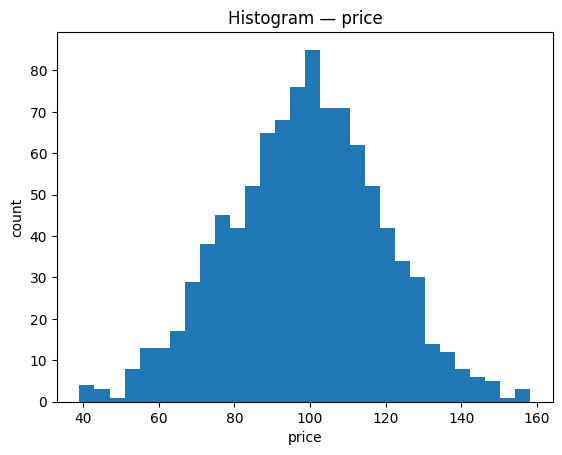

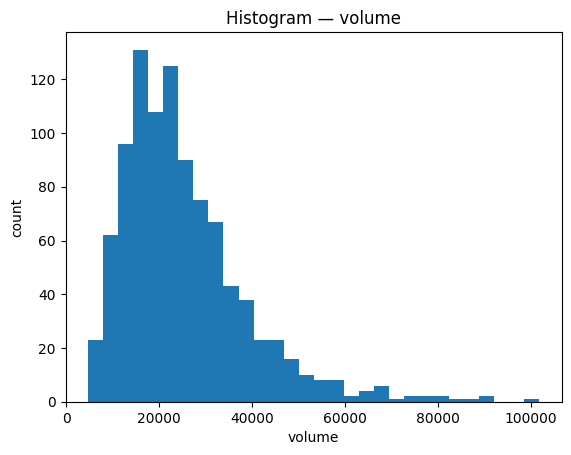

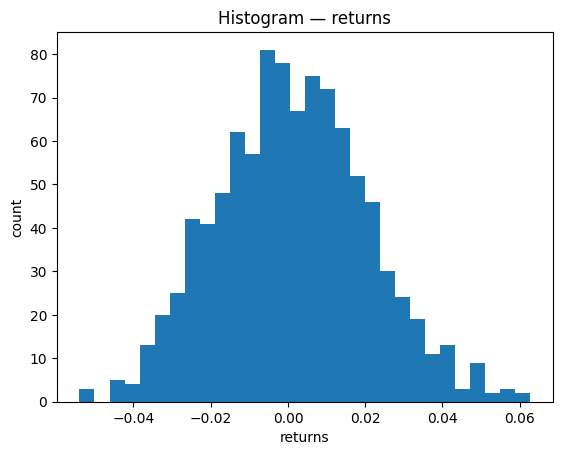

C:\Users\24614\AppData\Local\Temp\ipykernel_35736\2071492939.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[col].dropna(), vert=True, labels=[col])


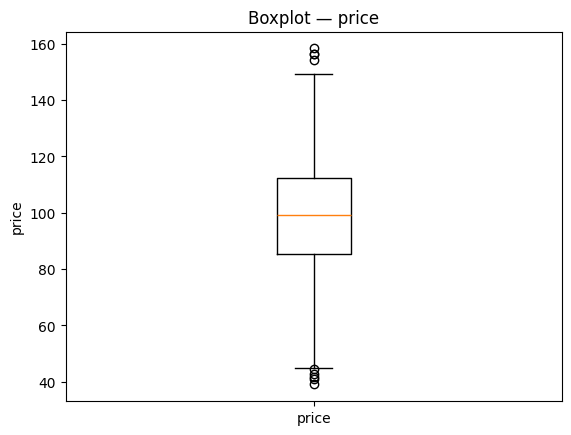

C:\Users\24614\AppData\Local\Temp\ipykernel_35736\2071492939.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[col].dropna(), vert=True, labels=[col])


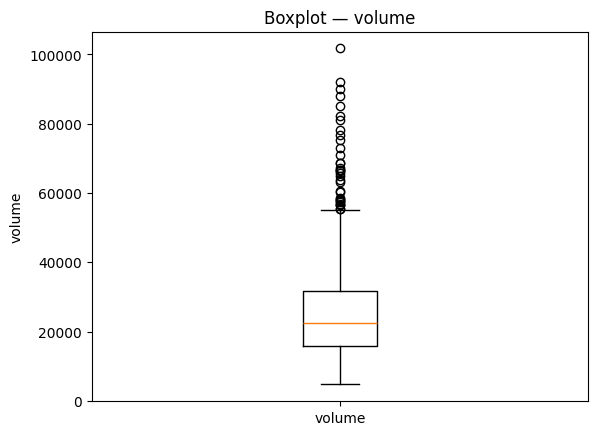

C:\Users\24614\AppData\Local\Temp\ipykernel_35736\2071492939.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[col].dropna(), vert=True, labels=[col])


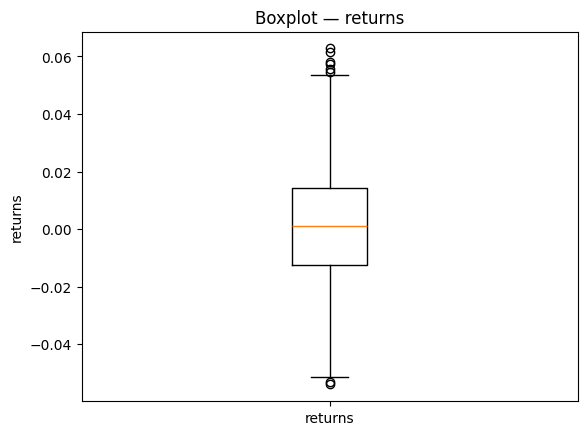

In [6]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plot_cols = num_cols[:3] if len(num_cols) >= 3 else num_cols
for col in plot_cols:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Histogram — {col}')
    plt.xlabel(col)
    plt.ylabel('count')
    plt.show()
for col in plot_cols:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.boxplot(df[col].dropna(), vert=True, labels=[col])
    plt.title(f'Boxplot — {col}')
    plt.ylabel(col)
    plt.show()

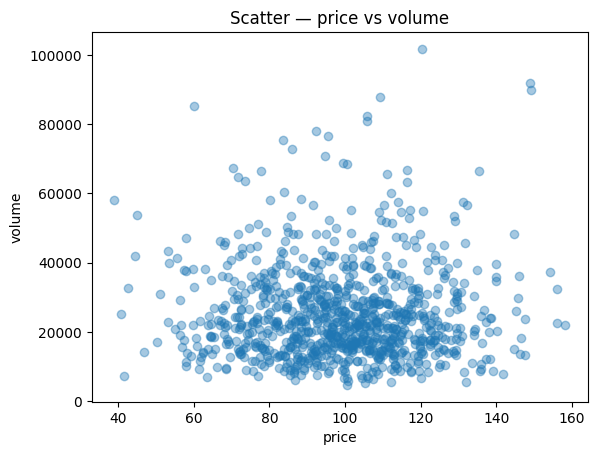

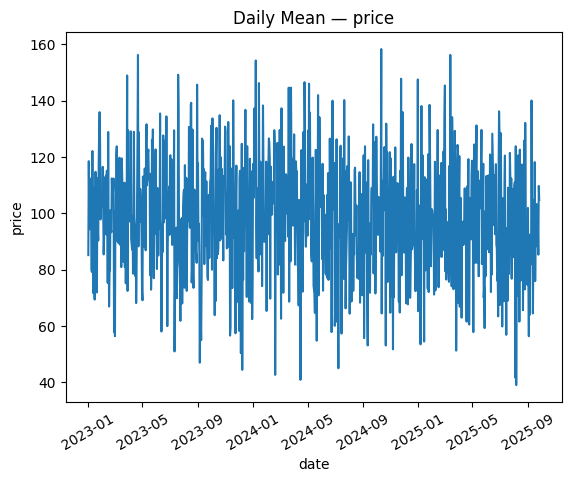

In [7]:
if len(num_cols) >= 2:
    x, y = num_cols[0], num_cols[1]
    import matplotlib.pyplot as plt
    plt.figure()
    plt.scatter(df[x], df[y], alpha=0.4)
    plt.title(f'Scatter — {x} vs {y}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
if 'date' in df.columns and len(num_cols) >= 1:
    line_col = num_cols[0]
    tmp = df[['date', line_col]].dropna().sort_values('date')
    daily = tmp.groupby('date', as_index=False)[line_col].mean()
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(daily['date'], daily[line_col])
    plt.title(f'Daily Mean — {line_col}')
    plt.xlabel('date')
    plt.ylabel(line_col)
    plt.xticks(rotation=30)
    plt.show()

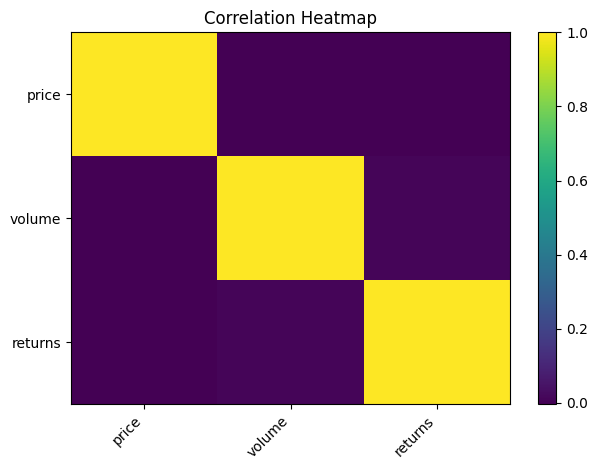

In [8]:
if len(num_cols) >= 2:
    corr = df[num_cols].corr(numeric_only=True)
    import matplotlib.pyplot as plt
    plt.figure()
    im = plt.imshow(corr, aspect='auto')
    plt.colorbar(im)
    plt.title('Correlation Heatmap')
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
    plt.yticks(range(len(num_cols)), num_cols)
    plt.tight_layout()
    plt.show()
    corr